## Introduction
The goal is to perform all data manipulation using only SQL, and use Python only to visualize the results.

The data I'll analyze comes from [Olist](https://olist.com/), a Brazillian e-commerce platform that connects small businesses to larger product marketplaces. Olist published a dataset containing 99441 orders from March 2016 to August 2018. The data is anonymized, so it doesn't contain names for buyers, sellers or products. I imported the original CSV files into an SQLite database with the following schema:

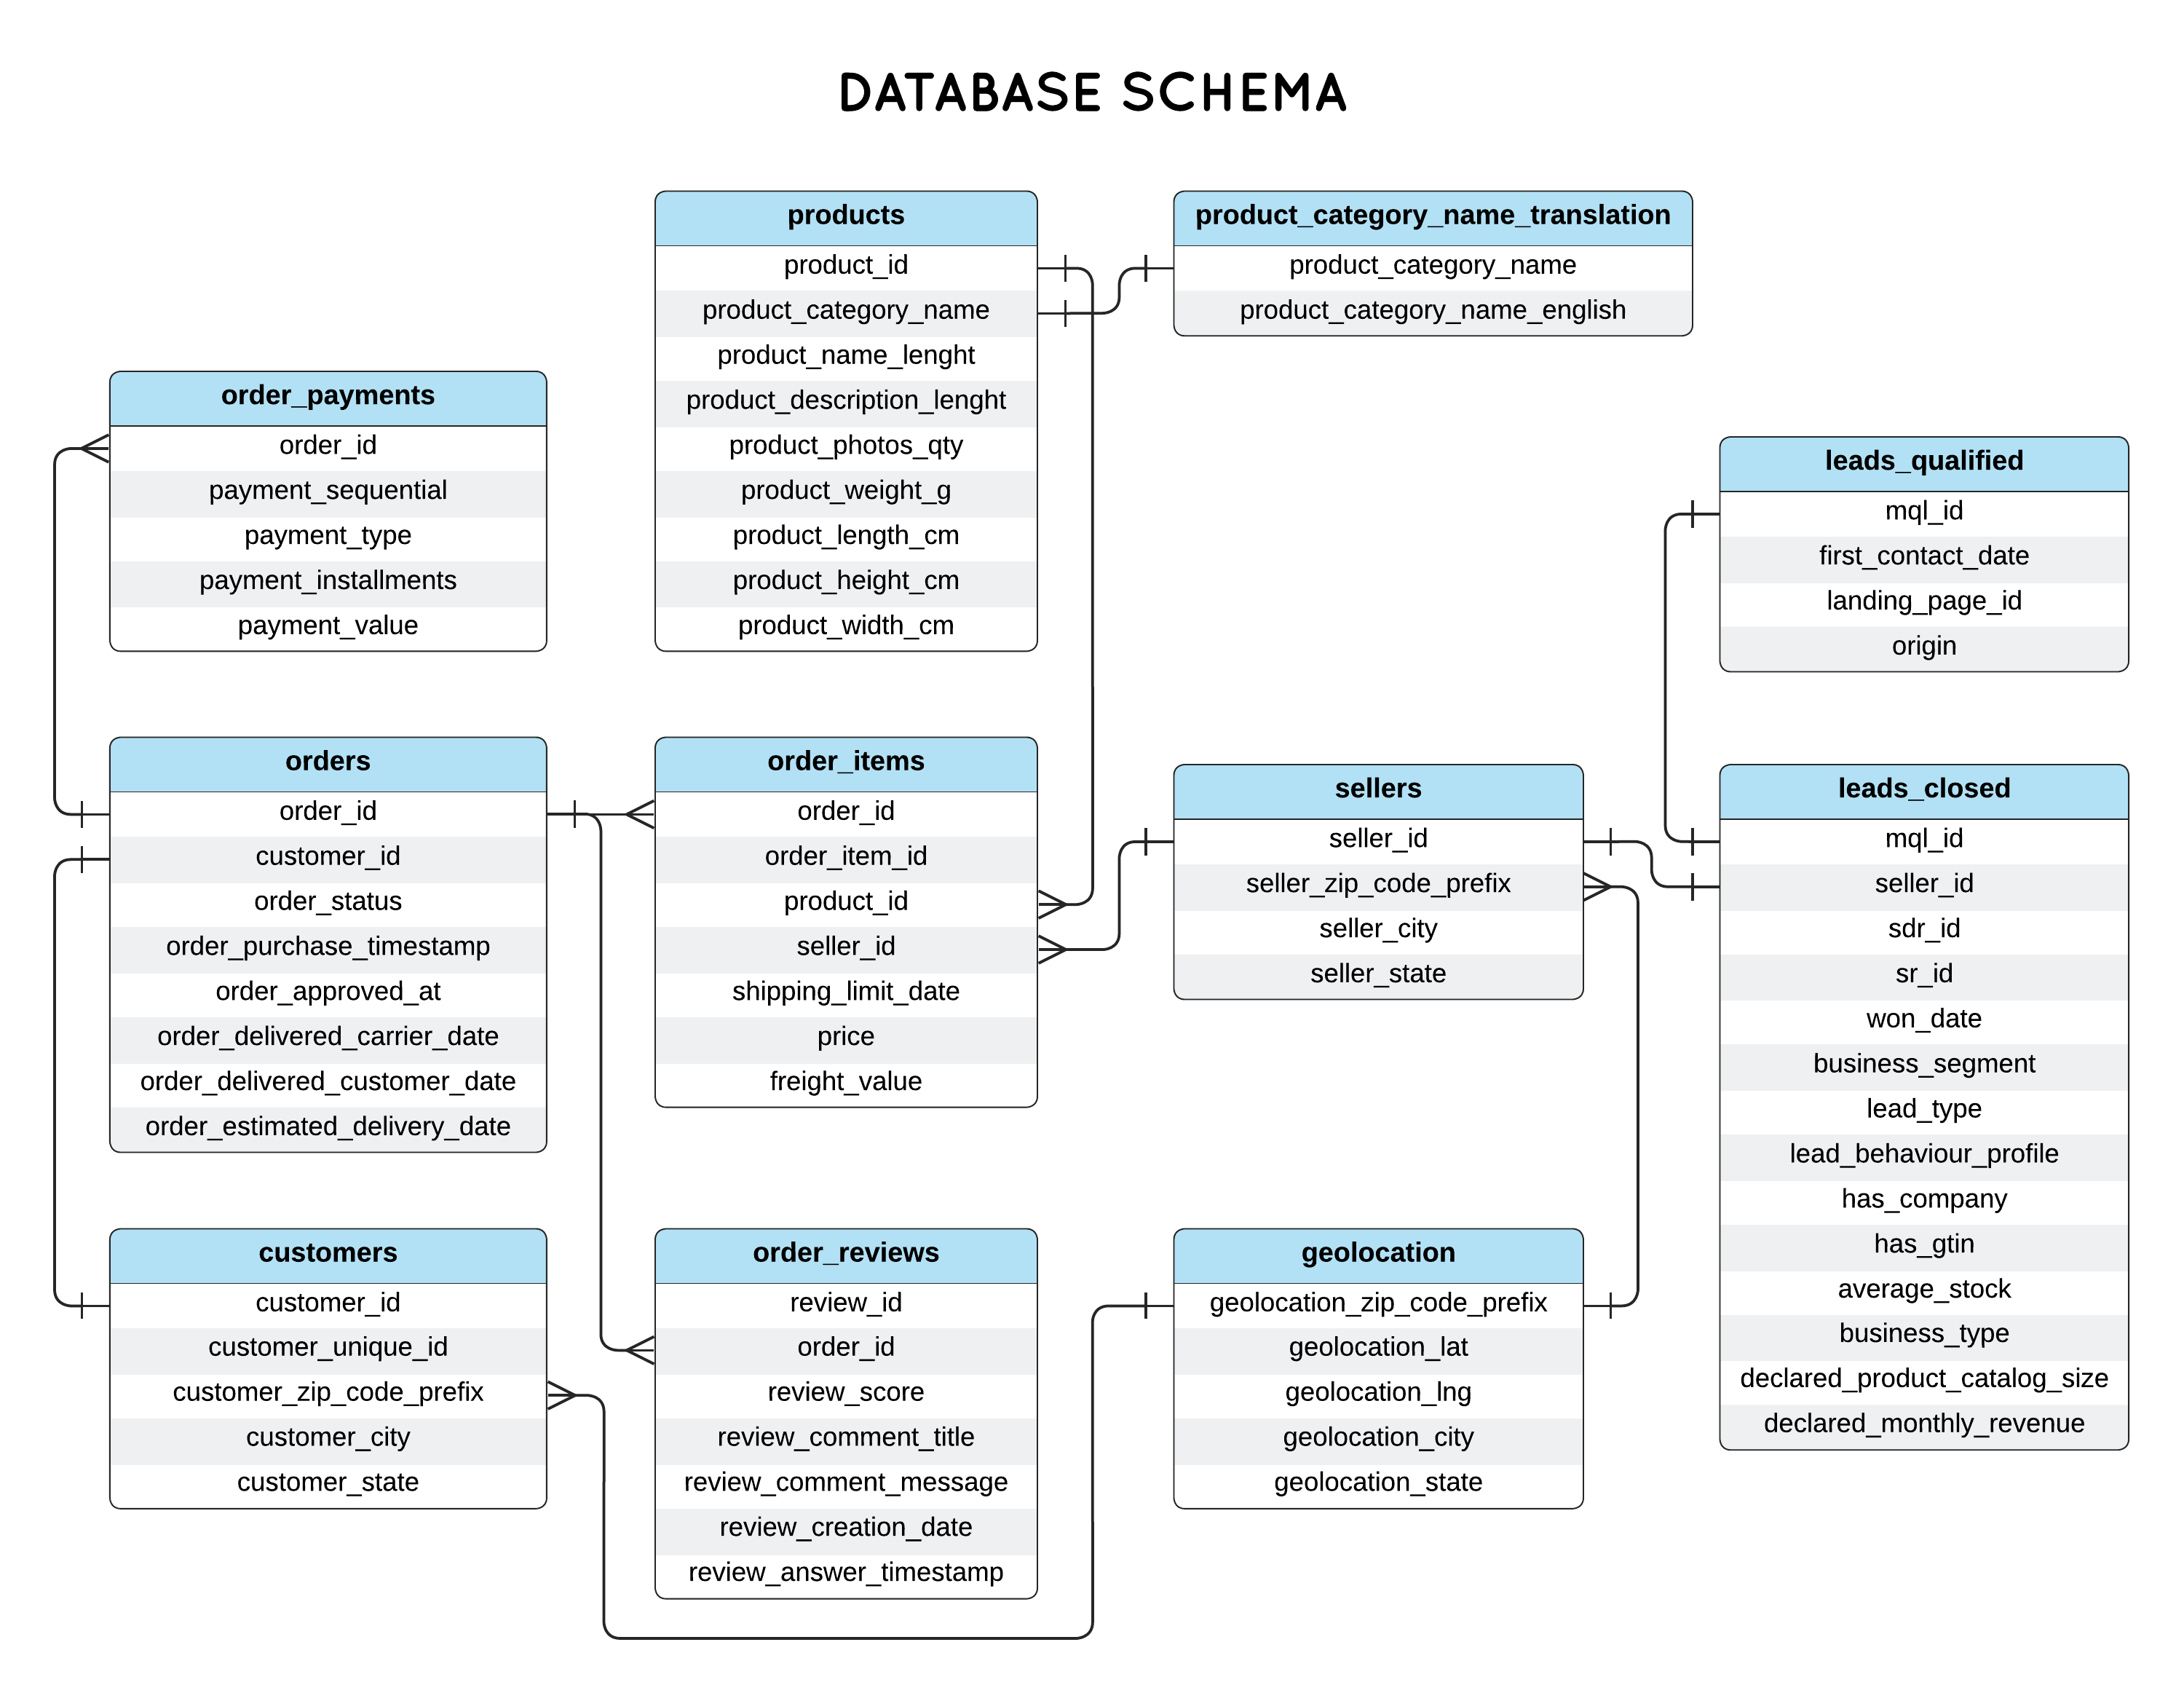

Data source: [Olist_dataset](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data)

Throughout this notebook I'll introduce you to each of these tables and we'll explore some of their fields. Have a look at the Table of Contents to see all the topics we'll cover. If you find this notebook useful, please upvote it to help others discover it.

### Connecting to the database

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3

In [ ]:
db_connection = sqlite3.connect("olist.sqlite")

To query the database, we just need to write an SQL query as a string and pass it to **pandas.read_sql_query** along with the database connection, which will return a pandas dataframe containing the query result

Throughout this notebook, we'll use the following function to explore the tables in the database using a def function:

In [ ]:
def view_table(table, limit):
    query = f"""
    SELECT *
    FROM {table}
    LIMIT {limit}
    """
    return pd.read_sql_query(query, db_connection)

### Number of Orders 
The **orders** table contains order_id, customer_id, order_status, which can be "delivered" or can be taken other values before the order is delivered:

In [ ]:
# view first 3 columns and  10 rows table orders
view_table("orders", 10).iloc[:,:3]

The next columns contain the timestamps that mark order status changes and an estimated delivery date at the last column:

In [ ]:
# Table orders, last 5 timestamp columns
view_table("orders", 10).iloc[:,3:]

Let's count the number of daily orders in the dataset using an SQL **GROUP BY** clause on the order timestamp and view the first 5 resulting rows:

In [ ]:
orders_per_day = """
SELECT
    DATE(order_purchase_timestamp) AS day,
    COUNT(*) AS order_count
FROM
    orders
GROUP BY day
"""
df = pd.read_sql_query(orders_per_day, db_connection)
df["day"] = pd.to_datetime(df["day"])
df.head()

In the previous output, we can see that the first days contain very few orders. Let's use **matplotlib** to visualize the frequency of orders per day:

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Increase the default font size globally
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 16


# Line plot
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(
    df["day"],
    df["order_count"]
)

ax.set_title("Number of orders per day")
ax.set_ylabel("Number of orders")
ax.axvline(17494, ls="-.", color="orange", alpha=0.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation = 45)
plt.show()



We can see there's a large spike of orders around Christmas, specifically on the 24th of December. The number of orders also seems to be increasing steadily over time as Olist's business grows. Also notice how there's very few data at the start and end of the timespan covered by the dataset, so we'll exclude these dates from some of our next queries

How are orders dustributed over the week? Are more orders placed on weekend? How about during the day? Do customers place more orders in the evening? We can answer these questions using a heatmap that plots the distribution of both on a grid. To plot a heatmap we need a matrix of counts of orders, where rows represent days of the week and columns represent hours of the day. Let's first extract the day of the wekk and the hour of the day from each order timestamp using the function STRFTIME:

In [ ]:
view_table("orders",5)

In [ ]:
order_day_hour = f"""
SELECT
    CASE STRFTIME("%w", order_purchase_timestamp) 
        WHEN '1' THEN 'Mon'
        WHEN '2' THEN 'Tue'
        WHEN '3' THEN 'Wed'
        WHEN '4' THEN 'Thu'
        WHEN '5' THEN 'Fri'
        WHEN '6' THEN 'Sat'
        WHEN '0' THEN 'Sun'
        END AS day_of_week_name,
    CAST(STRFTIME("%w", order_purchase_timestamp) AS integer) AS day_of_week_int,
    CAST(STRFTIME("%H", order_purchase_timestamp) AS integer) AS hour
FROM
    orders
"""
pd.read_sql_query(order_day_hour, db_connection)

To effciently generate a column of the count of orders for each hour of the day in an SQL query, we can use a Python list comprehension. This approach allows us to avoid writing 24 repetitive statements. We'll also use the previous query as CTE.

In [ ]:
count_orders_per_hour = ",\n".join([f"SUM(CASE WHEN hour = {i} THEN 1 END) AS '{i}'" for i in range(24)])

orders_per_day_of_the_week_and_hour = f"""
SELECT
    day_of_week_name,
    {count_orders_per_hour}
FROM 
    ({order_day_hour}) AS t1
GROUP BY day_of_week_int
ORDER BY day_of_week_int
"""

pd.read_sql_query(orders_per_day_of_the_week_and_hour, db_connection)

After executing the query, we just need to set the *day_of_the_week_name* column as the dataframe index to get the matrix we need to build the heatmap

In [ ]:
df = pd.read_sql_query(orders_per_day_of_the_week_and_hour, db_connection)

df = df.set_index("day_of_week_name")
df

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))

sns.heatmap(df, cmap="YlGnBu", cbar=False)
mean_orders = df.mean().mean()
for i in range(len(df)):
    for j in range(len(df.columns)):
        text_color = "white" if df.iloc[i,j] > mean_orders else "black"
        ax.text(j+0.5 ,i+0.5,int(df.iloc[i,j]), color=text_color, fontsize=11, ha="center", va="center")
        
ax.set_xlabel("Hour of the day")
ax.set_title("Number of orders by day of the week and hour of the day")

We can observe that most orders were placed during the weekdays from 10 AM to 16 PM with a small dip in sales around 12 PM due to lunchtime. Customers are also order through Olist in the evenings around 9PM 

Now we have examined the distribution of orders through time, we can have a look at the geographic distribution. The table **customers** contains the zip code prefix, city and state for each customer. Also notice there are two customers ids, *customer_unique_id* is the one that identigies each individual customer:

In [ ]:
view_table("customers", 5)

In [ ]:
view_table("orders", 5)

What are the cities with the most orders in the dataset? Let's build the query for the top 10 cities and view the result. We'll join the orders table to the customers table:

In [ ]:
orders_per_city = """
SELECT
    customer_city,
    UPPER(customer_city) AS city,
    COUNT(order_id) AS city_order_count
FROM
    orders o
    LEFT JOIN
    customers c ON o.customer_id = c.customer_id
GROUP BY customer_city
ORDER BY city_order_count DESC
LIMIT 10
"""

pd.read_sql_query(orders_per_city, db_connection)

Let's plot them using a bar plot. The **barh** function of `matplotlib` plots data from bottom to top, so we'll need to reverse it first. To achieve this using SQL, I'll use the previous query as a subquery to reverse the order of the results

In [ ]:
orders_per_city_reversed = f"""
SELECT
    *
FROM ({orders_per_city})
ORDER BY city_order_count
"""

top_cities = pd.read_sql_query(orders_per_city_reversed, db_connection)
top_cities.head()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(
    top_cities["city"], top_cities["city_order_count"]
)
ax.set_title("Top 10 cities by number of orders")
ax.set_xlabel("Number of orders")
ax.set_ylabel("City")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

As we can see, a lot more orders are placed in Sao Paulo and Rio de Janerio than in other cities, as you'd expect since these are also the largest cities in Brazil. We'll take a close look at the geographic distribution of orders later when we calculate customer lifetime value by zip code prefix.

### Order Prices
What's the average value of an order? Does Olist handle transactions of items of really low or really high value? Before aswering these questions, let's have a look at the **order_items** table. The table contains various ids and the price and shipping cost of the order's items. The currency is the Brazillian:

In [ ]:
# Table order_items, first 4 columns
view_table("order_items",5).iloc[:,:4]

In [ ]:
# Table order_items, last 2 columns
view_table("order_items", 5).iloc[:, 5:]

Let's answer our first question then: What's the average order price, consider both the cost of products and shipping? To start, let's fine the orders with the lowest and the highest costs:

In [ ]:
order_price_stats = """
WITH t1 AS (
SELECT
    o.order_id,
    SUM(oi.price + oi.freight_value) AS order_price
FROM
    order_items oi
    LEFT JOIN
    orders o ON oi.order_id = o.order_id
GROUP BY o.order_id
)
SELECT
    MIN(order_price) AS min_order_price,
    ROUND(AVG(order_price), 2) AS avg_order_price,
    MAX(order_price) AS max_order_price
FROM
    t1
"""
pd.read_sql_query(order_price_stats,db_connection)

The average order price is 160.58 BRL, which is around the cost of a pair of sports shoes in 2017 in Brazil. As we can see, the most expensive order is 13664.08, almost 100 times the average, meaning we probably have a right-tailed distribution, where most of the orders have low cost but there are orders with a very high cost. Let's see the variation in prices, this time separting product cost and shipping cost. To start, let's aggregate the product cost and shipping cost for each order:

In [ ]:
order_product_and_shipping_costs = """
SELECT
    o.order_id,
    SUM(price) AS product_cost,
    SUM(freight_value) AS shipping_cost
FROM
    order_items oi
    LEFT JOIN
    orders o ON oi.order_id = o.order_id
WHERE order_status = 'delivered'
GROUP BY o.order_id
"""

df = pd.read_sql_query(order_product_and_shipping_costs, db_connection)

df

Let's plot a histogram to see the distribution of product_cost and shipping_cost. Since the cost can take a huge range of values but most orders have a low cost, I'll limit each plot's x-axes to 500 reals and 80 reals respectively to highlight the distribution of the most common values:

In [ ]:
plt.figure(figsize=(15, 6))

# Histogram for total product cost
plt.subplot(1, 2, 1)
plt.hist(df["product_cost"], bins=1000, edgecolor="white", color='#6c87a3')
plt.title("Product cost < R$500")
plt.xlabel("Product cost (Braziian reals)")
plt.ylabel("Frequency")
plt.xlim([0, 500])

# Histogram for total shipping cost
plt.subplot(1, 2, 2)
plt.hist(df["shipping_cost"], bins=800, edgecolor= "white", color='#ad865f')
plt.title("Shipping cost < R$80")
plt.xlabel("Product cost (Brazilian reals)")
plt.xlim([0,80])

plt.show()

The value of products in any order can vary wildly and take from very low to very high values, although most orders contain products with a total cost under 200 reals.

Shipping cost is usually between 7-20 reals, and rarely below that, but it can also take a wide range of much higher values.

### Product Categories
Let's examine Olist's product categories by volume of sales. We'll start by looking at the *products* table, which contains 9 columns, but we'll only analyze product category and product weight

In [ ]:
view_table("products", limit=5).iloc[:,[0, 1, 5]]

There are 71 unique product categories. We can use a treemap to plot the relative sales of each category using areas. Since it will be challenging to visualize 71 categories, I'll choose the top 10 and group the rest in to "Other categories". To start, let's get the total sales for each category. We'll also use the **product_category_name_transalation** table which contains the category names in English:

In [ ]:
ranked_categories = """
SELECT
    product_category_name_english,
    SUM(price) AS sales,
    RANK() OVER(ORDER BY SUM(price) DESC) AS rank
FROM
    orders o 
    JOIN 
    order_items oi ON o.order_id = oi.order_id
    LEFT JOIN
    products p ON oi.product_id = p.product_id
    JOIN 
    product_category_name_translation t ON t.product_category_name = p.product_category_name
WHERE order_status = "delivered"
GROUP BY product_category_name_english
ORDER BY rank
"""

pd.read_sql_query(ranked_categories, db_connection)

In [ ]:
category_sales_summary = f"""
WITH t1 AS (
{ranked_categories}
)
SELECT
    product_category_name_english AS category,
    sales
FROM
    t1
WHERE rank <= 10
UNION ALL
SELECT
    "Other categories" AS category,
    SUM(sales) AS sales
FROM
    t1
WHERE rank >= 11
GROUP BY category
"""

df = pd.read_sql_query(category_sales_summary, db_connection)
df = df.sort_values("sales")
df

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.barh(
    df["category"],
    df["sales"] / 1000000
)
ax.set_title("Sales by category")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

We can gain more insights into the types of products these categories contain by visualizing the distribution of product weight by category using a set of box plots. To build the query for the weight of each product, we'll reuse the list of categories from the previous dataframe:

In [ ]:
top_10_categories = tuple(category for category in df["category"] if category != 'Other categories')

top_10_categories

It would be helpful to sort the boxes using the median of each category

In [ ]:
ordered_categories = f"""
SELECT
    product_weight_g AS weight,
    product_category_name_english AS category,
    ROW_NUMBER() OVER(PARTITION BY product_category_name_english ORDER BY product_weight_g) AS category_row_n,
    COUNT(*) OVER(PARTITION BY product_category_name_english) AS category_count
FROM
    products p
    JOIN
    order_items oi ON p.product_id = oi.product_id
    JOIN
    product_category_name_translation t ON  p.product_category_name = t.product_category_name
WHERE
    product_category_name_english IN {top_10_categories}
"""

df = pd.read_sql_query(ordered_categories, db_connection)
df

In [ ]:
categories_by_median = f"""
WITH OrderedCategories AS (
    {ordered_categories}
)
SELECT
    category
FROM OrderedCategories
WHERE
    -- Odd number of products: Select the middle row
    (category_count % 2 = 1 AND category_row_n = (category_count + 1) / 2) OR 
    -- Even number of products: Select the two middle rows to be averaged 
    (category_count % 2 = 0 AND category_row_n IN ((category_count / 2), (category_count / 2 + 1)))
ORDER BY weight
"""

categories_by_median_df = pd.read_sql_query(categories_by_median, db_connection)
categories_by_median_df

Now we can build the box plots, using the result of the previous query to order them:

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
order = categories_by_median_df["category"].to_list()
sns.boxplot(x="weight", y="category", data=df, order=order, showfliers=False)

ax.set_xlabel("Product weight (grams)")
ax.set_ylabel("Product category")
ax.set_title("Product weight by category (top 10 categories by sales)")
ax.set_xlim(-100, 10000)
plt.show()

As we can see at the top of the plot, there are 2 categories whose items are mostly under 2 Kg: "computer_accessories", "watches_gift"

## Order Delivery
As we saw at the start of this notebook, the **orders** table contains various timestamps:
- *order_purchase_timestamp*: The order is placed by the customer
- *order_approved_at*: The order is approved by Olist
- *order_delivered_carrier_date*: The order is handed to the shipping company
- *order_delivered_customer_date*: The customer receives the order
- *order_estimated_delivery_date*: Delivery date estimation

Each of these timestamps marks a change in the order shipping process. Let's see the average time for each stage of the order process, for each of the top 10 cities with the most orders: 

In [ ]:
view_table("customers",10)

In [ ]:
view_table("orders",10)

In [ ]:
tuple(top_cities["customer_city"])

In [ ]:
order_stage_times_top_10_citites = f"""
SELECT 
    UPPER(customer_city)
        AS city,
    AVG(JULIANDAY(order_approved_at) - JULIANDAY(order_purchase_timestamp))
        AS approved,
    AVG(JULIANDAY(order_delivered_carrier_date) - JULIANDAY(order_approved_at))
        AS delivered_to_carrier,
    AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_delivered_carrier_date))
        AS delivered_to_customer,
    AVG(JULIANDAY(order_estimated_delivery_date) - JULIANDAY(order_delivered_customer_date))
        AS estimated_delivery
FROM orders
    JOIN customers USING (customer_id)
WHERE  customer_city IN {tuple(top_cities['customer_city'])}
GROUP BY  customer_city
ORDER BY approved + delivered_to_carrier + delivered_to_customer DESC
"""

df = pd.read_sql_query(order_stage_times_top_10_citites, db_connection)
df = df.set_index('city')
df

Let's visualize the dataframe as a stacked bar plot:

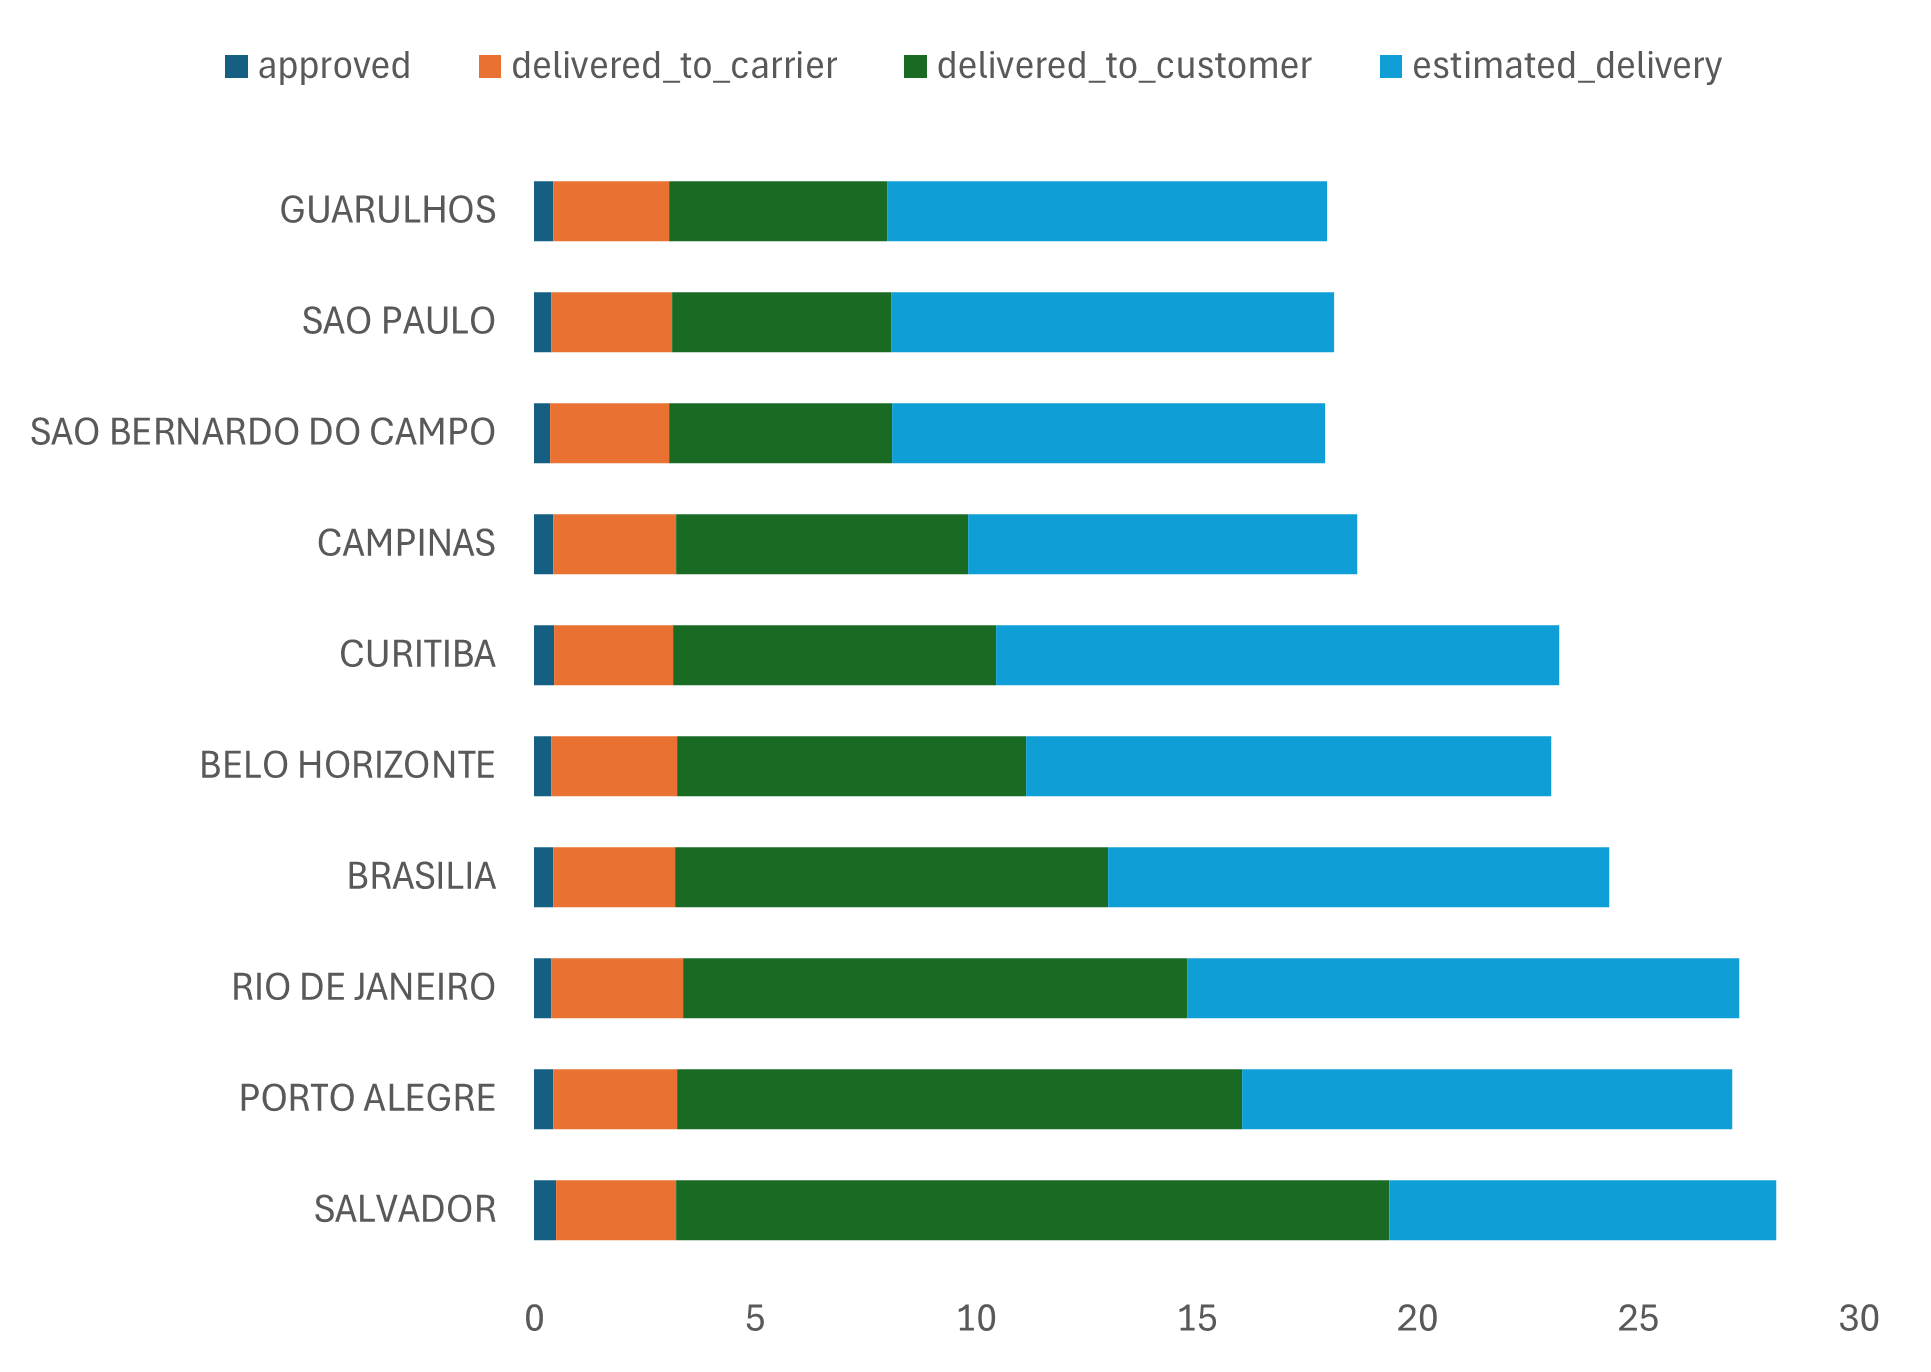

Looking at the chart, we can see that the approved and delivered_to_carrier process are consistently fast accros all cities, usually taking less than a few days, which suggest that the main inefficienceis do not occur at the start of the process. The real differences appear in the delivery-to-customer and estimated delivery stages. Cities close to Sao Paulo, such as Guarulhos and Sao Bernardo do Campo, experience shorter average daily times, while more distant locations like Salvador, Porto Alegrem and Brasilia face longer customer delivery stages, sometimes stretching beyond ten days. The estimated delivery component dominates the total time across all cities, often exceeding twenty days, which raises the question of whether this reflects actual shipping performance or simply conservative system estimates applied to certain regions. Proximity to logistics hubs clearly influences delivery speed, but to fully explain the variation, it would be important to examine the role of local carrier availability and whether product mix or regional demand surges are contributing to extended timelines.

Is there a seasonal variation in shipping times? To answer this question, we can create a line plot of daily average shipping time. I'll select orders from the period from june 2017 to june 2018:

In [ ]:
daily_avg_shipping_time = """
SELECT
    DATE(order_purchase_timestamp) AS purchase_date,
    AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp)) AS avg_delivery_time
FROM
    orders
WHERE order_purchase_timestamp >= "2017-06-01" AND order_purchase_timestamp <= "2018-06-30"
GROUP BY DATE(order_purchase_timestamp)
"""

df=pd.read_sql_query(daily_avg_shipping_time, db_connection)
df

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(
    df["purchase_date"].astype("datetime64[ns]"),
    df["avg_delivery_time"],
    label="Daily average"
)
ax.axhline(df["avg_delivery_time"].mean(), color="red", ls="-.", label="Yearly average")
ax.set_title("Average delivery time (from June 2017 to June 2018)")
ax.set_ylabel("Days")
ax.legend()

plt.show()

This time series makes the seasonal variation very clear. For most of 2017, average delivery times stayed close to or slightly below the yearly mean of about 13 days. Starting in November, however, there is a sharp and sustained increase that peaks in early 2018, with daily averages often exceeding 18–20 days. This spike coincides with the holiday shopping period (Black Friday, Christmas, and New Year sales) when order volumes surge, suggesting that congestion in the logistics network leads to longer shipping times. Moreover, in February-March, there is a [postal strike](https://www.riotimesonline.com/brazil-news/rio-business/brazilian-postal-workers-remain-on-strike-in-rio-and-sao-paulo/) that happned in certain states of Brazil at the time which could lead to the delay in delivery time.  After March 2018, delivery performance steadily improves, with averages dropping below the yearly mean and reaching their lowest levels in May–June 2018, under 10 days, which implies not only recovery after peak season but possibly improvements in logistics operations.

### Order reviews
Our databse also includes an **order_reviews** table. Users can score an order from 1 to 5 and write a comment on the order. Let's see the columns we'll use in our analysis

In [ ]:
view_table("order_reviews", 100)

Let's count how many orders there are for each review source:

In [ ]:
review_score_count = """
SELECT
    review_score,
    COUNT(*) AS count
FROM
    order_reviews
GROUP BY review_score
"""

df = pd.read_sql_query(review_score_count, db_connection)
df

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
colors = ['#BC2023', '#EB442C', '#F8B324', '#6da814', '#0C6B37']

sns.barplot(data = df, x="review_score", y="count", hue="review_score", palette=colors, dodge=False)
ax.set_title("Distribution of review scores")
ax.set_xlabel("Review score")
ax.set_ylabel("Count")
ax.legend().remove()

plt.show()

We can see that most review scores are very positive, but there's also a fair number of unsatisfied customers. What's the cause? To answer this question, let's create a word cloud of the comments with a score of 1 or 2. First we'll ned to concatenate all messages using the GROUP_CONCAT function:

In [ ]:
negative_comments = """
SELECT
    GROUP_CONCAT(review_comment_message," ") AS comments
FROM
    order_reviews
WHERE review_score IN (1,2)
"""

negative_comments_df = pd.read_sql(negative_comments, db_connection)["comments"][0]

negative_comments_df[:150]

In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, background_color="white").generate(negative_comments_df)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Translating these words to English, you'll se that the main cause of negative comments is related to shipping delays. Dissatisfaction with the product quality or other order errors seem to be secondary.

## Customer Segmentation
Now we will use a simple segmentation method such as RFM to identify group of customers according to three metrics:
- **Recency**: How recently did the customer place the last order?
- **Frequency**: How often does the customer place orders?
- **Monetary value**: How much does the customer spend on average?

Afterward, each customer is assigned to a category according to its RFM scores. This segmentation process is particularly useful for personalized marketing to improve customer service by addressing the specific needs of different customer groups.

The following SQL query is a bit longer than the previous but not too complex. I'll break it down in 3 steps:
1. Calculate each of the three RFM scores in three CTEs using the NTILE function, which ranks each customer from 1-5 in the given score.
2. Assign each customer to one of 11 groups, using the method outlined in this [article by Mark Rittman](https://www.rittmananalytics.com/blog/2021/6/20/rfm-analysis-and-customer-segmentation-using-looker-dbt-and-google-bigquery)
3. Calculate statistics for each group, so we can plot them by sales, recency and size

In [ ]:
view_table("customers",10)

In [ ]:
view_table("orders",10)

In [ ]:
view_table("order_items",10)

In [ ]:
rfm_buckets = """
-- 1. Calculate RFM scores
WITH RecencyScore AS (
SELECT
    customer_unique_id,
    MAX(order_purchase_timestamp) AS last_purchase,
    NTILE(5) OVER(ORDER BY MAX(order_purchase_timestamp) DESC) AS recency
FROM
    orders o 
LEFT JOIN
    customers c ON o.customer_id = c.customer_id
WHERE order_status = 'delivered'
GROUP BY customer_unique_id
),
FrequencyScore AS (
SELECT
    customer_unique_id,
    COUNT(order_id) AS total_orders,
    NTILE(5) OVER(ORDER BY COUNT(order_id) DESC) AS frequency
FROM
    orders o
    LEFT JOIN
    customers c ON o.customer_id = c.customer_id
WHERE order_status = 'delivered'
GROUP BY customer_unique_id
),
MonetaryScore AS (
SELECT
    customer_unique_id,
    SUM(price) AS total_spent,
    NTILE(5) OVER(ORDER BY SUM(price) DESC) AS monetary
FROM
    orders o
    LEFT JOIN
    customers c ON o.customer_id = c.customer_id
    JOIN
    order_items oi ON o.order_id = oi.order_id
WHERE order_status = 'delivered'
GROUP BY customer_unique_id
),

-- 2. Assign each customer to a group 
RFM AS (
SELECT 
    customer_unique_id, last_purchase, total_orders, total_spent,
    CASE
        WHEN recency = 1 AND frequency + monetary IN (1, 2, 3, 4) THEN "Champions"
        WHEN recency IN (4, 5) AND frequency + monetary IN (1, 2) THEN "Can't Lose Them"
        WHEN recency IN (4, 5) AND frequency + monetary IN (3, 4, 5, 6) THEN "Hibernating"
        WHEN recency IN (4, 5) AND frequency + monetary IN (7, 8, 9, 10) THEN "Lost"
        WHEN recency IN (2, 3) AND frequency + monetary IN (1, 2, 3, 4) THEN "Loyal Customers"
        WHEN recency = 3 AND frequency + monetary IN (5, 6) THEN "Needs Attention"
        WHEN recency = 1 AND frequency + monetary IN (7, 8) THEN "Recent Users"
        WHEN recency = 1 AND frequency + monetary IN (5, 6) OR recency = 2 AND frequency + monetary IN (5, 6, 7, 8) 
            THEN "Potential Loyalists"
        WHEN recency = 1 AND frequency + monetary IN (9, 10) THEN "Price Sensitive"
        WHEN recency = 2 AND frequency + monetary IN (9, 10) THEN "Promising"
        WHEN recency = 3 AND frequency + monetary IN (7, 8, 9, 10) THEN "About to Sleep"
        END AS RFM_Bucket
    FROM RecencyScore
        JOIN FrequencyScore USING (customer_unique_id)
        JOIN MonetaryScore USING (customer_unique_id)
        )

-- 3. Calculate group statistics for plotting
SELECT
    RFM_Bucket,
    AVG(JULIANDAY('now') - JULIANDAY(last_purchase)) AS avg_days_since_purchase,
    AVG(total_spent / total_orders) AS avg_sales_per_customer,
    COUNT(*) AS customer_count
FROM RFM
GROUP BY RFM_Bucket
"""
df = pd.read_sql_query(rfm_buckets, db_connection)

df

Let's visualize this by using scatter plot with average recency on the x-axis, average sales per customer on the y-axis and cricle size to represent the amount of customers in each group:

In [ ]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['avg_days_since_purchase'], df['avg_sales_per_customer'],
    s=df['customer_count']*0.55, c=sns.color_palette('Set3', len(df)))
plt.xlabel('Average days since the last purchase', fontsize=14)
plt.ylabel('Average sales per customer', fontsize=14)
plt.title('RFM segmentation of customers')
plt.grid(True)
for i, text in enumerate(df["RFM_Bucket"]):
    plt.annotate(text, (df["avg_days_since_purchase"][i], df["avg_sales_per_customer"][i]), ha="center", va="center")
plt.gca().invert_xaxis()
plt.xlim(3050, 2550)
plt.ylim(0, 380)
plt.show()


What stands out is that the **Champions** segment is exactly where it should be: recent buyers with high spend. On the opposite end, the **Lost** and **Hibernating**

The chart highlights three main tiers. At the top, **Champions and Loyal Customers** are your current revenue core—recent, high-spending buyers who need to be protected with recognition and consistent engagement. The largest group is **Potential Loyalists**: they buy recently with moderate spend, making them the prime growth lever. Converting even a portion into Loyal Customers will shift overall revenue significantly. Finally, **Recent Users, Promising, and Price Sensitive** form the entry pipeline. They are fresh but low-spend, and the key is nurturing: driving repeat purchases for Recents, building habits for Promising, and keeping Price Sensitive engaged with clear value offers. On the left side, **Hibernating and Lost** are mostly low-return, but **Can’t Lose Them** deserves selective reactivation given their high past value.

To gain more insight into how loyal are people who buy through Olist:

In [ ]:
repeat_customer_proportion = """
WITH CustomerOrders AS (
    SELECT
        customer_unique_id,
        COUNT(order_id) AS order_count
    FROM
        orders o
        LEFT JOIN
        customers c ON c.customer_id = o.customer_id
    GROUP BY customer_unique_id
),
t1 AS (
SELECT
    CASE
        WHEN order_count > 1 THEN 'repeat' ELSE 'one-time' END AS order_type
FROM
    CustomerOrders
)
SELECT
    order_type,
   ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM t1), 1) AS proportion
FROM
    t1
GROUP BY order_type
"""

df = pd.read_sql_query(repeat_customer_proportion, db_connection)
df

In [ ]:
fig, ax = plt.subplots()
ax.pie(df["proportion"], labels = df["order_type"], startangle=90, autopct="%.0f%%")
ax.set_title("Proportion of one-time vs repeat customers")
fig.set_facecolor("white")
plt.show()

The RFM chart showed many customers in the **Potential Loyalist** and **Recent/Promising** groups, but the pie chart reveals that only **3% actually place repeat orders**. This means most customers buy once and never return, so very few move up into **Loyal Customers** or **Champions**. The main issue is not getting new customers, but keeping them. To improve, the business should focus on turning first-time buyers into repeat buyers through quick follow-up offers, reminders, and loyalty programs. Even a small increase in repeat orders would strengthen the high-value segments and create more stable growth.

## Customer Lifetime value

Customer Lifetime Value (CLV) is a crucial metric in business that measures the predicted value of the future relationship with a customer. Let's calculate CLV for the customers in our dataset. To achieve this, we'll introduce a new table **order_payments**, which contain payments made and payment methods used:

In [ ]:
view_table('order_payments', 5)

To start, we'll calculate each of the components of CLV for each client:
- Purchase Frequency (PF), the number of orders a client placed.
- Average Order Value (AOV), the sum of payments divided by the number of orders.
- Average Customer Lifespan (ACL), the number of weeks from the first to the last order, with a minimum value of 1.

To make the code more readable, I'll use a CTE to gather the necessary data, then in the main query I'll calculate each of the CLV components:

In [ ]:
clv = """
WITH CustomerData AS (
    SELECT
        c.customer_unique_id,
        c.customer_zip_code_prefix AS zip_code_prefix,
        COUNT(DISTINCT o.order_id) AS order_count,
        SUM(payment_value) AS total_payment,
        JULIANDAY(MIN(order_purchase_timestamp)) AS first_order_day,
        JULIANDAY(MAX(order_purchase_timestamp)) AS last_order_day
    FROM
        orders o
        JOIN
        customers c ON o.customer_id = c.customer_id
        JOIN
        order_payments op ON op.order_id = o.order_id
    GROUP BY c.customer_unique_id
)
SELECT
        customer_unique_id,
        zip_code_prefix,
        order_count AS PF,
        total_payment / order_count AS AOV,
        CASE
            WHEN (last_order_day - first_order_day) < 7 THEN
                1
            ELSE
                (last_order_day - first_order_day) / 7
            END AS ACL
    FROM CustomerData
"""

pd.read_sql_query(clv, db_connection)

Since my goal is to build a map of the distribution of CLV around Brazil, we'll also need to add the latitude and longitude of each zip code prefix, which can be found in the table geolocation:

In [ ]:
view_table('geolocation', 5)

Using the previous query as CTE, we can calculate the average CLV and the number of customers for each zip code prefix. To calculate CLV we just multiply each of its terms:
**CLV = PF * AOV * ACL**


In [ ]:
avg_clv_per_zip_prefix = f"""
WITH CLV AS (
    {clv}
)
SELECT
    zip_code_prefix AS zip_prefix,
    AVG(PF * AOV * ACL) AS avg_CLV,
    COUNT(customer_unique_id) AS customer_count,
    geolocation_lat AS latitude,
    geolocation_lng AS longitude
FROM CLV
    JOIN geolocation ON CLV.zip_code_prefix = geolocation.geolocation_zip_code_prefix
GROUP BY zip_code_prefix
"""

df = pd.read_sql(avg_clv_per_zip_prefix, db_connection)
df

With these data we can create an interactive map using the `folium` library. For each zip code prefix a circle is drawn in the map, using opacity to indicate CLV and size to indicate the number of customers

In [ ]:
import folium

map = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)
for i, zip_prefix in df.iterrows():
    folium.CircleMarker(
        location=[zip_prefix['latitude'], zip_prefix['longitude']],
        radius=0.1*np.sqrt(zip_prefix['customer_count']),
        color=None,
        fill_color='#85001d',
        fill_opacity=0.1+0.1*np.sqrt(zip_prefix['avg_CLV']/df['avg_CLV'].max()),
        popup=(
            f"<b>Zip Code Prefix:</b> {int(zip_prefix['zip_prefix'])}<br>"
            f"<b>Average CLV:</b> {int(zip_prefix['avg_CLV'])}<br>"
            f"<b>Customers:</b> {int(zip_prefix['customer_count'])}"
        )
    ).add_to(map)
map

The geographic heatmap shows that customers are heavily concentrated in Brazil’s Southeast and South, with São Paulo, Rio de Janeiro, and Belo Horizonte standing out as the main hubs. These regions combine both high customer counts and strong average CLV, making them the core markets to prioritize. In contrast, smaller inland and southern areas contribute fewer customers but sometimes higher average CLV, suggesting targeted opportunities in niche high-value clusters outside the main urban centers.

## Sellers 
The table **sellers** contains 3095 sellers that use Olist's services. Let's have a look at the first few rows:

In [ ]:
view_table('sellers', 5)

In [ ]:
view_table('order_items', 5)

In [ ]:
view_table('orders', 5)

In [ ]:
view_table('order_reviews', 5)

Are most sellers small, with a few sales, or large companies with a high volume of sales? How do review scores vary among the different sales? We can answer both of those questions using a scatterplot. Let's get the data we need from the **sellers** table: 

In [ ]:
seller_review_scores_and_sales = """
SELECT
    s.seller_id,
    AVG(orr.review_score) AS avg_review_score,
    SUM(oi.price) AS total_sales,
    COUNT(o.order_id) AS num_orders
FROM
    sellers s
    LEFT JOIN
    order_items oi ON s.seller_id = oi.seller_id
    LEFT JOIN
    orders o ON o.order_id = oi.order_id
    LEFT JOIN
    order_reviews orr ON orr.order_id = o.order_id
GROUP BY s.seller_id
HAVING COUNT(o.order_id) > 10
"""

df = pd.read_sql_query(seller_review_scores_and_sales, db_connection)
df

We'll create a scatterplot where each point is a seller, the y-axis indicates its average order review score, the x-axis shows total sales, using a logarithmic scale, since most sellers have very low sales. We'll also use both color and size to represent the number of orders:

In [ ]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x='total_sales', y='avg_review_score', size='num_orders', sizes=(10, 500), 
                hue='num_orders', palette='flare', alpha=0.7)
plt.xscale('log')
plt.xlabel('Total sales (logarithmic scale)')
plt.ylabel('Average review score')
plt.title('Sellers: Review score vs Sales')
plt.legend(title='Number of Orders')
plt.show()

The chart shows that most sellers have moderate sales with review scores between 3.5 and 4.5. A small group dominates total sales, combining high order volume with strong reviews above 4.0. Some sellers maintain good reviews but low sales, suggesting growth potential, while a few with weaker reviews risk long-term performance. Overall, the marketplace is concentrated around a few high-performing sellers.

Let's build another plot to help us understand the distribution of sellers by order size. We'll sort the sellers into 4 groups according to the number of orders the dispatched
- Group 1: Sellers with 1-9 orders
- Group 2: Sellers with 10-99 orders
- Group 3: Sellers with 100-199 orders
- Group 4: Sellers with 1000 or more orders

In [ ]:
bucketed_sellers = """
SELECT
    seller_id,
    CASE 
        WHEN COUNT(order_id) BETWEEN 1 AND 9 THEN '1-9 orders'
        WHEN COUNT(order_id) BETWEEN 10 AND 99 THEN '10-99 orders'
        WHEN COUNT(order_id) BETWEEN 100 AND 999 THEN '100-999 orders'
        ELSE '1000+ orders'
    END AS bucket
FROM order_items
GROUP BY seller_id
"""

pd.read_sql_query(bucketed_sellers, db_connection).head(5)

In [ ]:
sellers_per_bucket = f"""
WITH t1 AS (
    {bucketed_sellers}
)
SELECT
    bucket, 
    COUNT(seller_id) AS seller_count
FROM
    t1
GROUP BY bucket
"""

seller_buckets = pd.read_sql_query(sellers_per_bucket, db_connection)
seller_buckets


In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(data = seller_buckets, x =seller_buckets["bucket"], y=seller_buckets["seller_count"], hue="bucket", palette="flare", dodge=False)

ax.set_title("Number of sellers by orders (grouped)")
ax.set_xlabel("Amount of orders per seller")
ax.set_ylabel("Number of seller")
plt.tight_layout()
plt.show()

We can verify most sellers are small, with very few having more than 1000 orders

Do larger sellers have lower shipping times? To answer this question let's build a plot of the distribution of shipping time for each of the previous four groups. We'll reuse the previous CTE in the query to get the data we need:

In [ ]:
seller_shipping_times = f"""
WITH BucketedSellers AS (
    {bucketed_sellers}
)
SELECT
    bucket,
    BucketedSellers.seller_id,
    JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp)
        AS delivery_time
FROM orders
    JOIN order_items USING (order_id)
    JOIN BucketedSellers USING (seller_id)
WHERE order_status = 'delivered'
"""

df = pd.read_sql_query(seller_shipping_times, db_connection)
df

Let's draw four boxplots, corresponding to each bar in the previous plot:

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
palette = sns.color_palette('flare', len(seller_buckets['bucket']))
sns.boxplot(x="bucket", y="delivery_time", data=df, order=seller_buckets["bucket"], showfliers=False, hue="bucket", 
            palette=palette[1:]+palette[:1], dodge=False)
plt.title("Delivery time by seller order volume")
plt.xlabel("Sellers with...")
plt.ylabel("Shipping time (days)")
plt.show()

Looking at delivery times by seller size, large sellers (1,000+ orders) show more variation and often slower averages than smaller sellers. This could be due to operational strain, broader shipping networks, or higher reliance on logistics partners. Smaller sellers, though fewer in orders, sometimes deliver faster and more consistently. This highlights a trade-off between scale and efficiency: while bigger sellers dominate sales, their fulfillment speed can be less reliable compared to leaner, localized sellers.

## Conclusion
The analysis shows that Olist’s growth depends less on acquiring new customers and more on improving repeat purchases and seller efficiency. Logistics delays are the biggest source of customer dissatisfaction, which feeds directly into poor reviews and weak retention. Meanwhile, most sales come from a small group of sellers and a few key regions, meaning expansion should focus on strengthening seller operations and customer loyalty programs in those core markets.